# Rod Sheet Dynamics

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

from tyssue import config
from tyssue import Sheet, SheetGeometry as geom
from tyssue.dynamics import SheetModel as model
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.solvers.isotropic_solver import bruteforce_isotropic_relax

from tyssue.io import hdf5
from tyssue.draw.threejs_draw import view_3js
from tyssue.draw.plt_draw import quick_edge_draw, plot_scaled_energies

import markdown
from IPython.display import HTML

%matplotlib inline

from tyssue.utils.utils import _to_2d, _to_3d

from tyssue.draw.plt_draw import plot_forces

Reseting datasets values with new specs


(30, 3)
Succesful first min: True
Succesful 2nd min: True
minimize message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


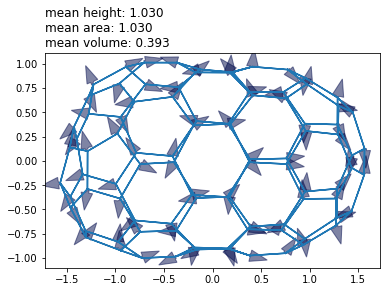

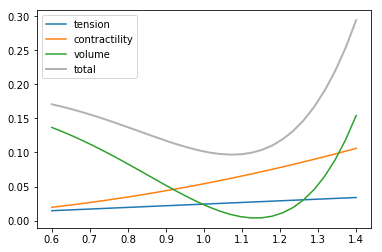

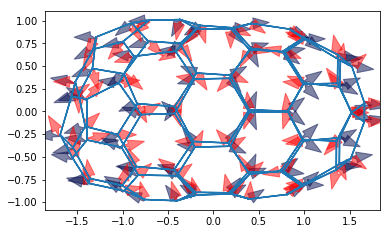

In [28]:
# Load the data

dsets = hdf5.load_datasets('../data/hf5/ellipsoid_sheet.hf5',
                           data_names=['vert', 'edge', 'face'])

# Set geometry

sheet = Sheet('rod', dsets,
              config.geometry.rod_sheet())

geom.reset_scafold(sheet)
geom.update_all(sheet)


# Tweak model parameters

dyn_specs = config.dynamics.quasistatic_sheet_spec()
dyn_specs['vert']['basal_shift'] = 0.
dyn_specs['face']['prefered_vol'] = 0.6
dyn_specs['face']['contractility'] = 0.02
dyn_specs['edge']['line_tension'] = 0.12


sheet.update_specs(dyn_specs, reset=True)


# Quick report on the scales of the model
report = '\n'.join(
    ('mean height: {:.3f}'.format(
          sheet.face_df.height.mean()),
     'mean area: {:.3f}'.format(
          sheet.face_df.height.mean()),
     'mean volume: {:.3f}'.format(
          sheet.face_df.vol.mean()),
      ))


fig, ax = plot_forces(sheet, geom, model,
                      list('zx'), scaling=1,
                      ax=None)

figures = {'forces': fig}
ax.set_title(geom_str, loc='left')
plt.savefig('../data/png/prev_forces.png')

report += '\n![Forces](../data/png/prev_forces.png)'     

scales = np.linspace(0.6, 1.4, 30)
fig, ax = plot_scaled_energies(sheet, geom, model,
                              scales, ax=None)
figures['energies'] = fig
plt.savefig('../data/png/energies.png')

report += '\n![Energies](../data/png/energies.png)'     


res = Solver.find_energy_min(sheet, geom, model)
print('Succesful first min: {}'.format(res['success']))


res = Solver.find_energy_min(sheet, geom, model)
res['success']
print('Succesful 2nd min: {}'.format(res['success']))
print('minimize message: {}'.format(res['message']))


scaling = 20

fig, ax = plot_forces(sheet, geom, model, list('zx'),
                      scaling=scaling, ax=None)

fig, ax = plot_forces(sheet, geom, model,
                      ['z', 'x'], scaling=scaling, ax=ax,
                      approx_grad=Solver.approx_grad,
                      **{'grad':{'color': 'r'}})

fig.savefig('../data/png/post_forces.png')


report += '\n![Post Forces](../data/png/prev_forces.png)'     

#display()


In [36]:
import markdown
from IPython.display import HTML

HTML(markdown.markdown(report))